In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from dataset_path import output_path
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Dropout, Activation, LSTM,  Input, concatenate
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from tensorflow.keras import optimizers, metrics
import matplotlib.pyplot as plt
import os
from thesis_helper import * 
from sklearn.decomposition import PCA
pd.set_option('float_format', '{:.3f}'.format)
path = output_path

output_path = os.path.join(path, "Figure3")
if not os.path.exists(output_path):
    os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0
result_list = []


In [2]:
X_train,y_train,X_test,y_test = preprocessing(path,df_train,df_test)

Before filtering: training size = 334480 , testing size = 83620
After filtering: training size = 176213 , testing size = 44063


In [3]:
df_train

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,...,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,183244,14328106,NaN,32336955,2159-11-08 15:13:00,2159-11-09 01:47:00,F,WHITE,WALK IN,HOME,...,0.000,5.000,9.000,84.333,3,9,8,1,1,1
1,376935,18860711,NaN,35614382,2159-10-24 06:19:00,2159-10-24 14:31:00,F,WHITE,WALK IN,HOME,...,4.000,1.000,5.000,65.000,0,4,2,1,1,1
2,291579,16860825,NaN,37485359,2203-01-07 17:45:00,2203-01-08 07:00:00,F,BLACK/AFRICAN AMERICAN,AMBULANCE,HOME,...,3.000,0.000,14.000,106.667,7,4,3,1,1,1
3,210524,14971343,29116455.000,34783406,2207-07-11 18:24:00,2207-07-11 22:37:00,F,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,...,0.000,3.000,5.000,116.667,5,9,8,1,1,2
4,69316,11648387,NaN,39707189,2181-01-23 09:25:00,2181-01-23 13:27:00,M,WHITE,WALK IN,HOME,...,0.000,0.000,16.000,116.000,9,13,9,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334475,200654,14730006,NaN,30085487,2200-02-25 14:42:00,2200-02-25 18:21:00,F,BLACK/AFRICAN AMERICAN,WALK IN,HOME,...,0.000,0.000,5.000,97.000,1,0,2,0,0,1
334476,237191,15574665,NaN,31650665,2196-12-23 17:22:00,2196-12-24 07:49:00,F,WHITE,WALK IN,HOME,...,0.000,0.000,12.000,68.667,2,8,9,1,1,1
334477,171350,14053403,NaN,35645781,2151-02-04 05:11:00,2151-02-04 07:51:00,M,WHITE,AMBULANCE,HOME,...,8.000,2.000,1.000,96.667,2,4,5,0,0,1
334478,214391,15061792,23421297.000,35124553,2112-07-10 20:41:00,2112-07-11 02:11:00,F,WHITE,WALK IN,ADMITTED,...,2.000,4.000,4.000,87.667,2,4,3,1,1,2


In [9]:
import lightgbm as lgb
import imblearn
from imblearn.pipeline import Pipeline
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss

from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
start = time.time()
clf1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
clf2 = CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


eclf = VotingClassifier(estimators=[('LGB', clf1), ('CatB', clf2), ('XGB', clf3)],voting='soft',weights = [1,1,1])
i = 1
e_r_ens = []
while i < len(X_train.columns):
    model1 = PCA(n_components=i)

    X_pc1 = model1.fit_transform(X_train)
    Xtest_PC1 = model1.transform(X_test)

    eclf.fit(X_pc1,y_train)
    probs = eclf.predict_proba(Xtest_PC1)
    train_r = ROC_result(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed);
    e_r_ens.append(train_r[0])
    i += 1

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\basic.py:599: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


[LightGBM] [Info] Number of positive: 8404, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 176213, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047692 -> initscore=-2.994119
[LightGBM] [Info] Start training from score -2.994119
0:	learn: 0.2378650	total: 153ms	remaining: 9.05s
1:	learn: 0.1958180	total: 166ms	remaining: 4.83s
2:	learn: 0.1913411	total: 179ms	remaining: 3.4s
3:	learn: 0.1911695	total: 192ms	remaining: 2.69s
4:	learn: 0.1910697	total: 205ms	remaining: 2.26s
5:	learn: 0.1910448	total: 218ms	remaining: 1.96s
6:	learn: 0.1910439	total: 230ms	remaining: 1.74s
7:	learn: 0.1910433	total: 242ms	remaining: 1.57s
8:	learn: 0.1910259	total: 255ms	remaining: 

56

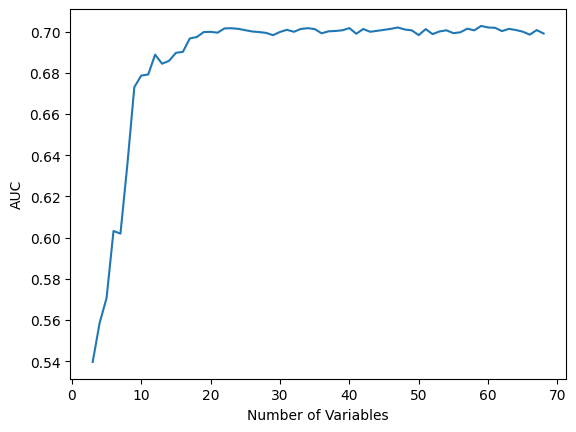

In [15]:
import matplotlib.pyplot as plt 
import numpy as np 
plt.plot(range(3, len(e_r_ens) + 3), e_r_ens)
plt.xlabel("Number of Variables")
plt.ylabel("AUC")
e_r_ens.index(max(e_r_ens))

[LightGBM] [Info] Number of positive: 167809, number of negative: 167809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14535
[LightGBM] [Info] Number of data points in the train set: 335618, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.6498481	total: 30.6ms	remaining: 1.8s
1:	learn: 0.6436352	total: 62.7ms	remaining: 1.82s
2:	learn: 0.6391583	total: 92.4ms	remaining: 1.75s
3:	learn: 0.6355493	total: 123ms	remaining: 1.72s
4:	learn: 0.6334720	total: 152ms	remaining: 1.67s
5:	learn: 0.6314630	total: 181ms	remaining: 1.63s
6:	learn: 0.6304861	total: 211ms	remaining: 1.6s
7:	learn: 0.6298729	total: 237ms	remaining: 1.54s
8:	learn: 0.6290773	total: 265ms	remaining: 1.5s
9:	learn: 0.6284897	total: 293ms	remaining: 1.47s
10:	learn: 0.6277198	total: 323ms	remaining: 1.44s
11:	le

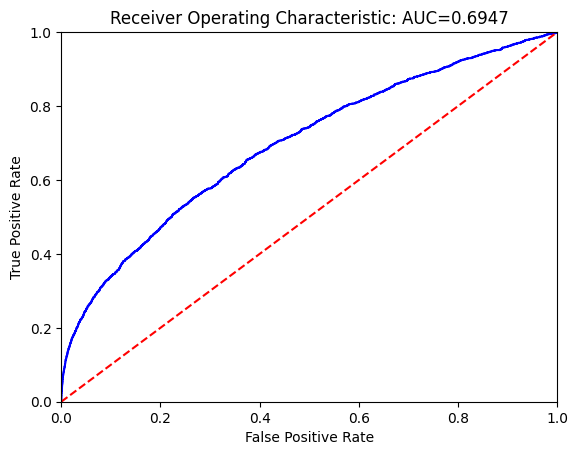

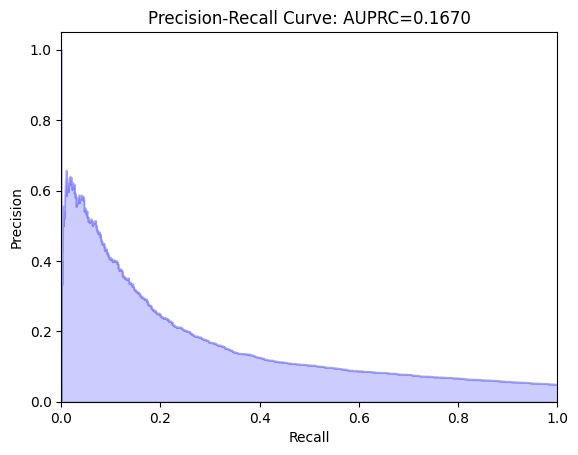

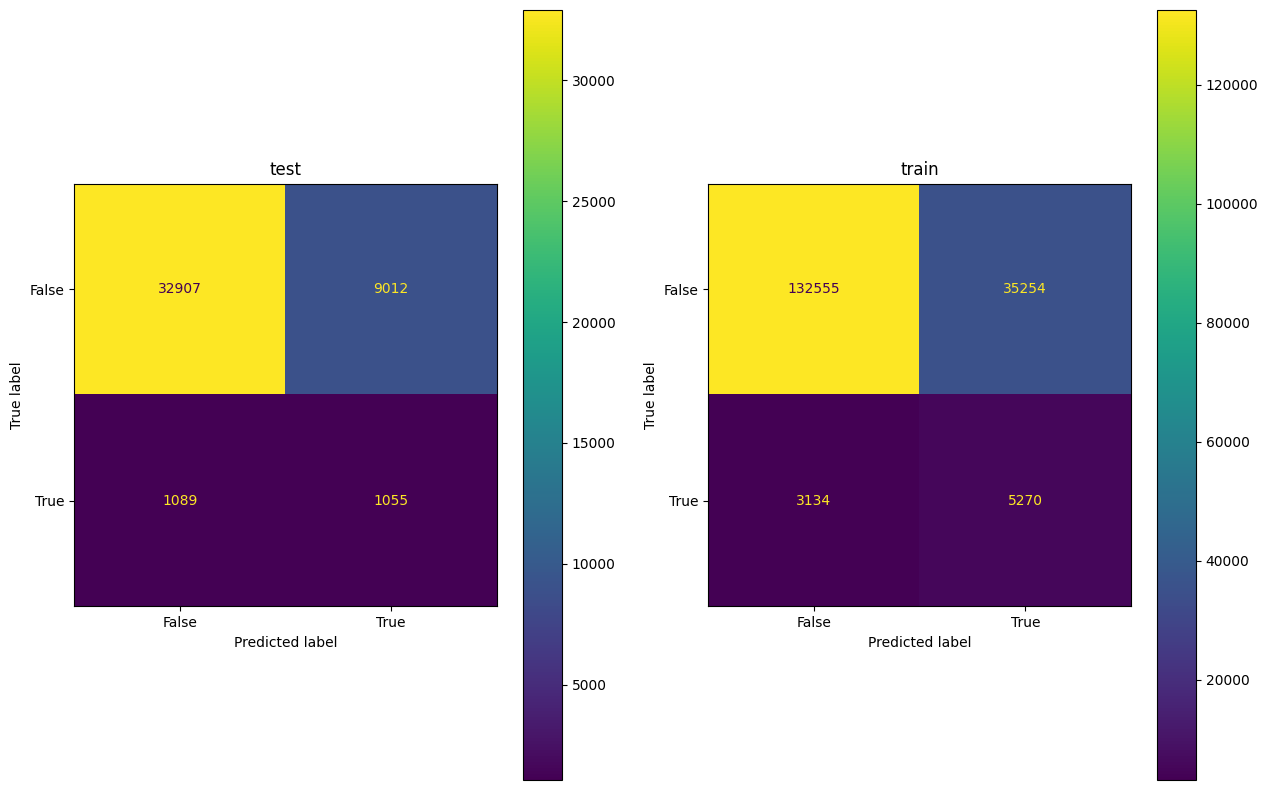

In [16]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
PCA_m = PCA(n_components=57)
train_img_pca = PCA_m.fit_transform(X_train)
test_img_pca = PCA_m.transform(X_test)

ros = RandomOverSampler(sampling_strategy='minority',random_state=6) # 6:6961
X_ros, y_ros = ros.fit_resample(train_img_pca,y_train)

eclf.fit(X_ros, y_ros)
probs = eclf.predict_proba(test_img_pca)
train_r = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed);
CM_plot_train_test(eclf,train_img_pca,y_train,test_img_pca ,y_test)

In [17]:
find_sens_speci(eclf,test_img_pca,y_test)

(0.17279502088281057,
 0.7707600481129292,
 0.7850139554855793,
 0.4920708955223881)

In [8]:
lo=LogisticRegression(random_state=1)
i = 1
e_r = []
while i < len(X_train.columns):
    model1 = PCA(n_components=i)

    X_pc1 = model1.fit_transform(X_train)
    Xtest_PC1 = model1.transform(X_test)

    lo.fit(X_pc1,y_train)
    probs = lo.predict_proba(Xtest_PC1)
    train_r = ROC_result(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed);
    e_r.append(train_r[0])
    i += 1

2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5
2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2.5 97.5


Text(0, 0.5, 'AUC')

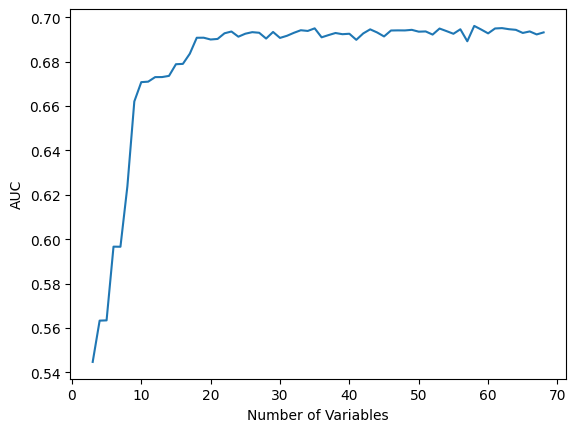

In [9]:
import matplotlib.pyplot as plt 
import numpy as np 
plt.plot(range(3, len(e_r) + 3), e_r)
plt.xlabel("Number of Variables")
plt.ylabel("AUC")

In [14]:
e_r.index(max(e_r))
e_r[55]

0.6960521744494446

In [3]:
def convert_data1(x_train,x_test):
    X_train1 = x_train.to_numpy().astype(np.float64)
    X_train1 = np.array(pad_sequences(X_train1))
    X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1],1)


    X_test1 = x_test.to_numpy().astype(np.float64)
    X_test1 = np.array(pad_sequences(X_test1))
    X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1],1)
    return X_train1,X_test1

In [4]:
modelx = PCA(n_components=55)
modelx.fit(X_train)
PCA_col = []
i = 0
while i < 55:
    PCA_col.append("PCA" + str(i))
    i += 1

train_img_pca = modelx.transform(X_train)
test_img_pca = modelx.transform(X_test)
train_img_pca = pd.DataFrame(train_img_pca,columns = PCA_col)
test_img_pca = pd.DataFrame(test_img_pca,columns = PCA_col)
train_data_gen, test_data_gen = convert_data1(train_img_pca, test_img_pca)

In [8]:
input_1  = Input(shape=(train_data_gen.shape[1], train_data_gen.shape[2]),  name='input_1')
dense_1 = Dense(96, activation='relu')(input_1)
lstm1  = LSTM(32, name='lstm1')(input_1)
lstm2  = LSTM(32, name='lstm2')(input_1)
x = concatenate([lstm2, lstm1])
output1 = Dense(64, activation='relu')(x)
output2 = Dense(1, activation='sigmoid')(output1)



lstm = Model(inputs=[input_1], outputs=output2)
lstm.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)
    ,]
epoch_num = 20
start = time.time()
lstm.fit(train_data_gen,y_train,epochs =epoch_num, batch_size = 200,callbacks=my_callbacks,
                    validation_data=(test_data_gen , y_test))
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
lstm.save('72h_ed_revisit_lstm')

Epoch 1/20
882/882 [==============================] - 40s 41ms/step - loss: 0.1996 - accuracy: 0.9514 - auc: 0.5804 - true_positives: 18.0000 - true_negatives: 167623.0000 - precision: 0.0882 - recall: 0.0021 - val_loss: 0.1876 - val_accuracy: 0.9513 - val_auc: 0.6272 - val_true_positives: 0.0000e+00 - val_true_negatives: 41919.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
882/882 [==============================] - 35s 40ms/step - loss: 0.1841 - accuracy: 0.9524 - auc: 0.6174 - true_positives: 25.0000 - true_negatives: 167794.0000 - precision: 0.6250 - recall: 0.0030 - val_loss: 0.1891 - val_accuracy: 0.9513 - val_auc: 0.6341 - val_true_positives: 0.0000e+00 - val_true_negatives: 41919.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
882/882 [==============================] - 35s 39ms/step - loss: 0.1825 - accuracy: 0.9524 - auc: 0.6241 - true_positives: 97.0000 - true_negatives: 167737.0000 - precision: 0.5740 - recall: 0.0115 - val_loss: 0.1

INFO:tensorflow:Assets written to: 72h_ed_revisit_lstm\assets


INFO:tensorflow:Assets written to: 72h_ed_revisit_lstm\assets


5507/5507 [==============================] - 27s 5ms/step
2.5 97.5
2.5 97.5


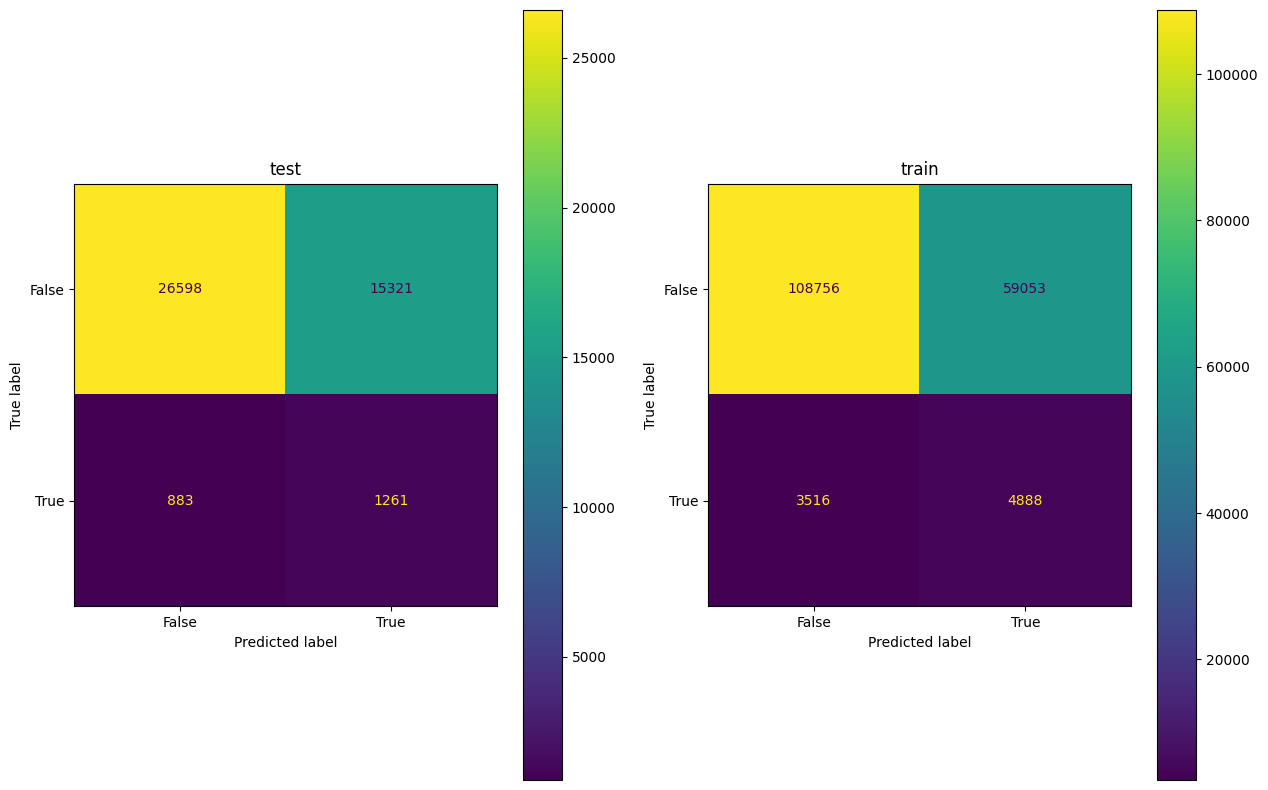

In [9]:
from sklearn import metrics
import matplotlib as plt
lstm = load_model('72h_ed_revisit_lstm')
CM_plot_train_test_DL(lstm,train_data_gen,y_train,test_data_gen,y_test)


1377/1377 [==============================] - 7s 5ms/step
AUC: 0.6573990154430738
AUPRC: 0.1471324584870179
Sensitivity: 0.5881529850746269
Specificity: 0.634509411006942
Score thresold: 0.0339811
2.5 97.5


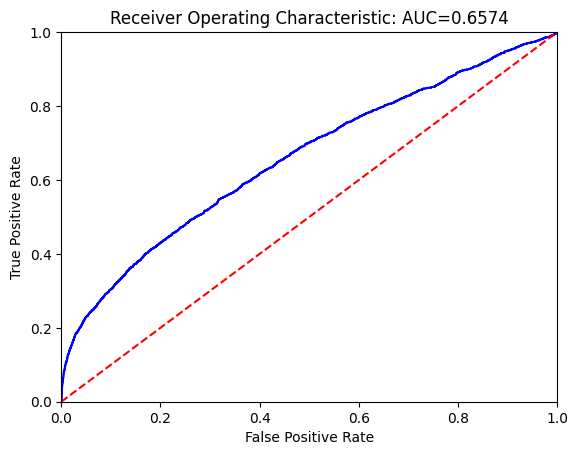

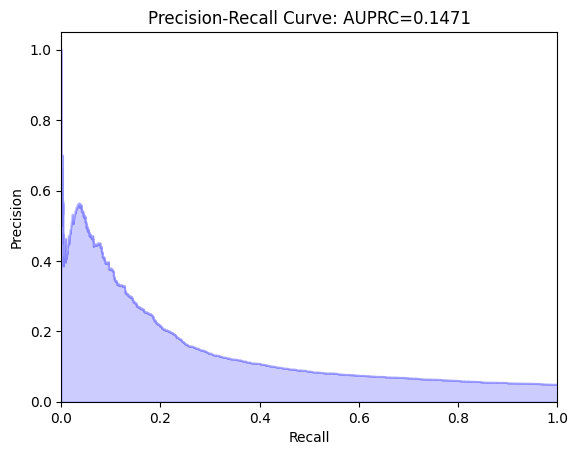

In [10]:
probs = lstm.predict([test_data_gen])
result_multilstm = PlotROCCurve(probs, y_test, ci=95, random_seed=0)

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.696791206335032
AUPRC: 0.16847434927089644
Sensitivity: 0.6166044776119403
Specificity: 0.6625396598201293
Score thresold: 0.45484065020381126
2.5 97.5


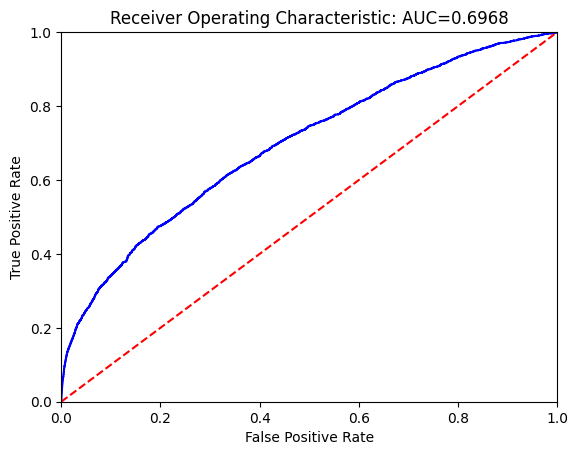

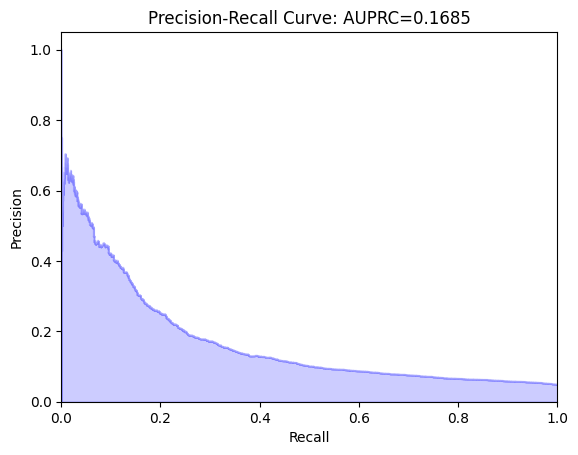

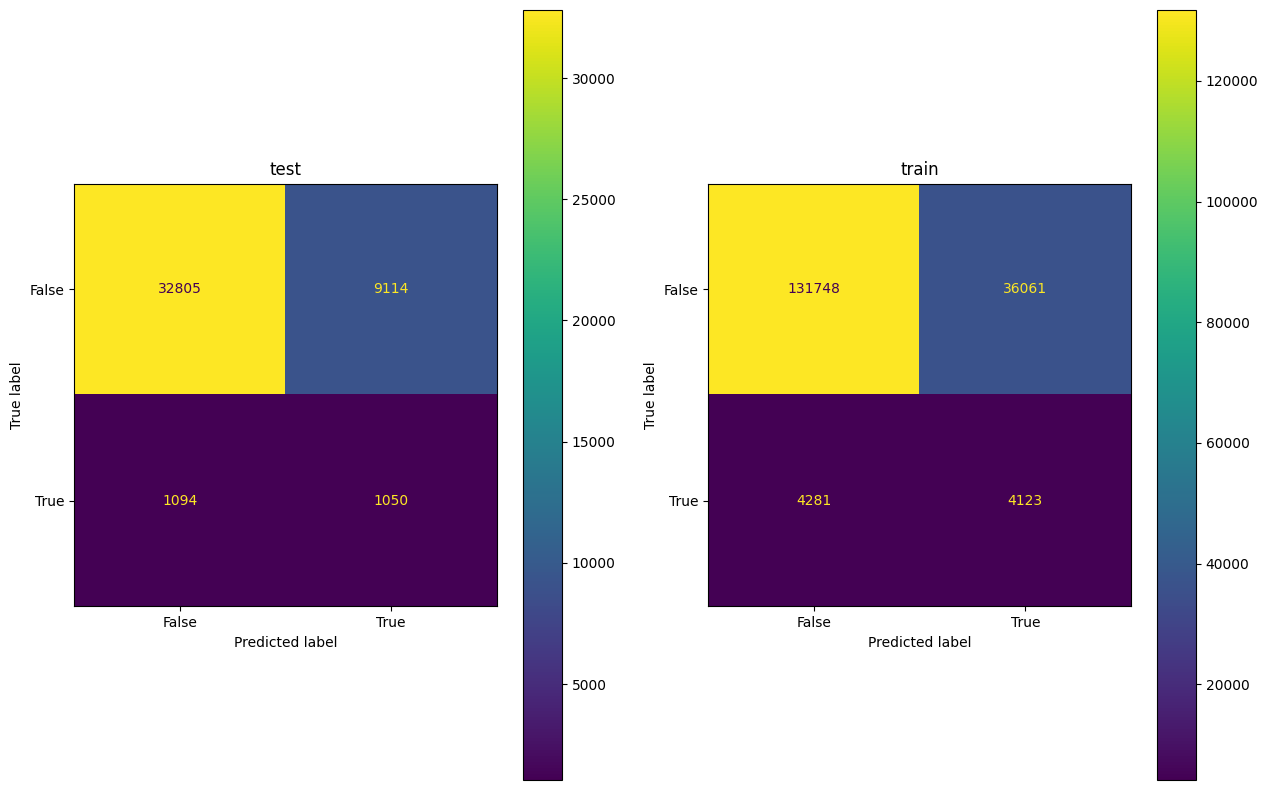

In [5]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
PCA_m = PCA(n_components=62)
train_img_pca = PCA_m.fit_transform(X_train)
test_img_pca = PCA_m.transform(X_test)

ros = RandomOverSampler(sampling_strategy='minority',random_state=6) # 6:6961
X_ros, y_ros = ros.fit_resample(train_img_pca,y_train)

lo=LogisticRegression(random_state=1)
lo.fit(X_ros, y_ros)
probs = lo.predict_proba(test_img_pca)
train_r = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed);
CM_plot_train_test(lo,train_img_pca,y_train,test_img_pca ,y_test)

In [8]:
find_sens_speci(lo,test_img_pca,y_test)

(0.17062073448163795,
 0.7683317068742482,
 0.7825806913332857,
 0.48973880597014924)

[LightGBM] [Info] Number of positive: 167809, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 335618, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
AUC: 0.6965363059817209
AUPRC: 0.16919550976257444
Sensitivity: 0.6072761194029851
Specificity: 0.6839380710417711
Score thresold: 0.45773290909752923
2.5 97.5


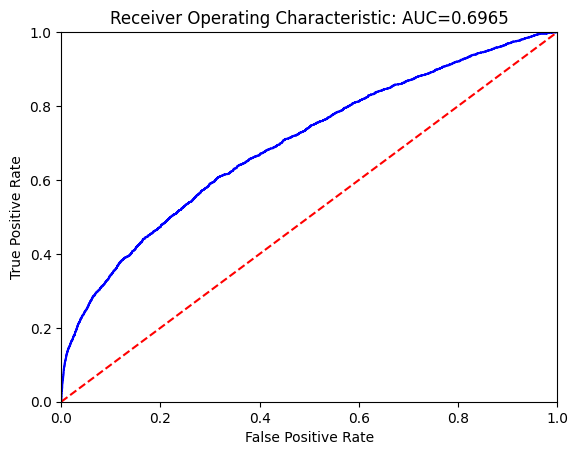

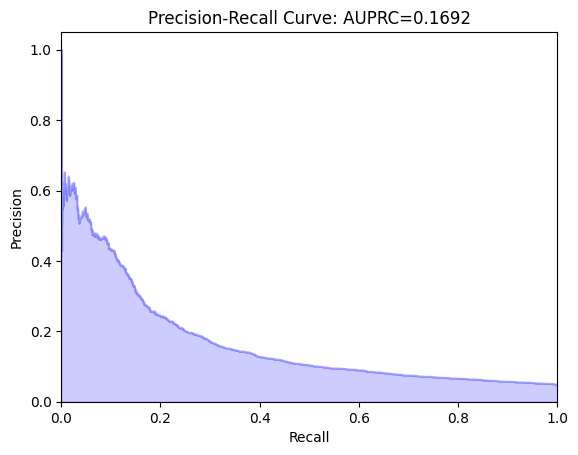

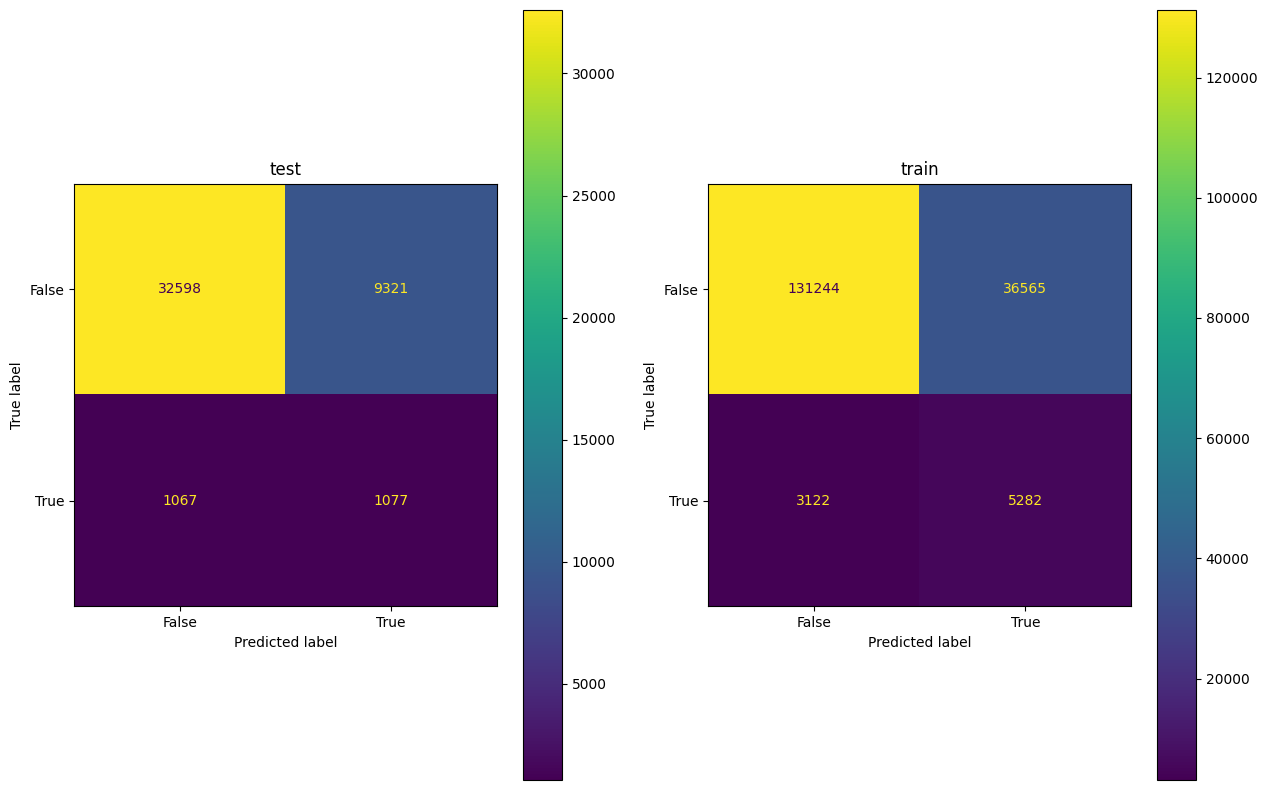

In [12]:
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC

# lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
# model = SelectFromModel(lsvc, prefit=True)
# X_new = model.transform(X_train)
# Xtest_new = model.transform(X_test)
ros = RandomOverSampler(sampling_strategy='minority',random_state=8) # 6:6961
X_ros, y_ros = ros.fit_resample(X_train,y_train)
# feature_name,X_new,Xtest_new = varianceThreshold_fs(X_train, y_train,X_test)

clf1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
clf1.fit(X_ros, y_ros)
probs = clf1.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
CM_plot_train_test(clf1,X_train,y_train,X_test,y_test)

In [23]:
import lightgbm as lgb
import imblearn
from imblearn.pipeline import Pipeline
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss
ros = RandomOverSampler(sampling_strategy='minority',random_state=8) # 6:6961
undersample = NearMiss(version=2, n_neighbors=3)
X_ros, y_ros = ros.fit_resample(X_train,y_train)
X_ros, y_ros = undersample.fit_resample(X_ros, y_ros)
# X_ros,y_ros = X_train,y_train
# Random Oversampling
# SMOTE
# Borderline SMOTE
# SVM SMote
# k-Means SMOTE
# ADASYN
clf1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
clf2 = CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


eclf = VotingClassifier(estimators=[('NB', clf1), ('CB', clf2), ('LR', clf3)],voting='soft')
eclf.fit(X_ros, y_ros)
probs = eclf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
CM_plot_train_test(eclf,X_train,y_train,X_test,y_test)

MemoryError: Unable to allocate 210. GiB for an array with shape (167809, 167809) and data type int64

In [4]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor,CatBoostClassifier
PCA_m = PCA()
train_img_pca = PCA_m.fit_transform(X_train)
test_img_pca = PCA_m.transform(X_test)

ros = RandomOverSampler(sampling_strategy='minority',random_state=6) # 6:6961
X_ros, y_ros = ros.fit_resample(train_img_pca,y_train)
clf1 = GaussianNB()
clf2 = RandomForestClassifier()
clf3 = LogisticRegression(random_state=1)
eclf = VotingClassifier(estimators=[('NB', clf1), ('CB', clf2), ('LR', clf3)],voting='soft')
start = time.time()
eclf.fit(X_ros, y_ros)
runtime = time.time() - start
probs = eclf.predict_proba(test_img_pca)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Ensemble Classfier"]
results.extend(result)
results.append(runtime)
result_list.append(results)

KeyboardInterrupt: 

In [15]:
train_img_pca = pd.DataFrame(train_img_pca,columns = X_train.columns)
test_img_pca = pd.DataFrame(test_img_pca,columns = X_test.columns)
train_img_pca['stay_id'] = df_train['stay_id']
test_img_pca['stay_id'] = df_test['stay_id']
# ros = RandomOverSampler(sampling_strategy='minority')
# X_ros, y_ros = ros.fit_resample(train_img_pca,y_train)
train_img_pca['outcome_ed_revisit_3d'] = y_train
test_img_pca['outcome_ed_revisit_3d'] = y_test

In [16]:
train_data_gen, test_data_gen = convert_data(train_img_pca, test_img_pca, variable,df_vitalsign)

In [8]:
train_data_gen, test_data_gen = convert_data(train_img_pca, test_img_pca, variable,df_vitalsign)
# skip this cell if not retraining
input_1  = Input(shape=(train_data_gen.shape[1], train_data_gen.shape[2]),  name='input_1')
lstm1  = LSTM(5, name='lstm1')(input_1)
output2 = Dense(1, activation="sigmoid", name='out2f')(lstm1)
lstm = Model(inputs=[input_1], outputs=output2)
lstm.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30)
    ,
]
epoch_num = 200
start = time.time()
lstm.fit(train_data_gen,y_train,epochs =epoch_num, batch_size = 200,callbacks=my_callbacks,
                    validation_data=(test_data_gen , y_test))
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
# lstm.save('72h_ed_revisit_lstm')

AttributeError: module 'sklearn.metrics' has no attribute 'AUC'

5507/5507 [==============================] - 15s 3ms/step
2.5 97.5
2.5 97.5


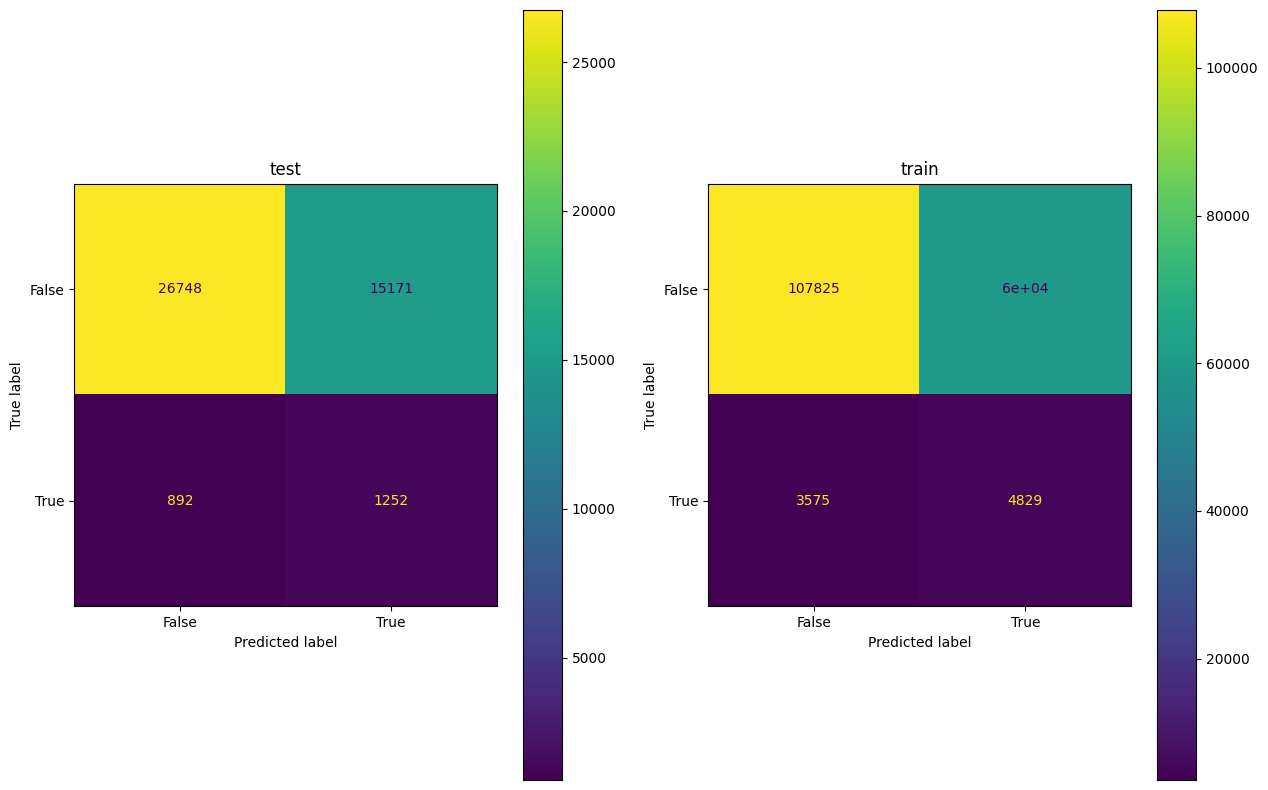

In [17]:
from sklearn import metrics
import matplotlib as plt
lstm = load_model('72h_ed_revisit_lstm')
CM_plot_train_test_DL(lstm,train_data_gen,y_train,test_data_gen,y_test)
